In [1]:
import numpy as np
import sklearn
import pandas as pd
import sys
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm
import warnings

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from collections import defaultdict, Counter
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, homogeneity_score, silhouette_score, classification_report

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
SEED = 2023

In [3]:
df1 = pd.read_csv('electricity-normalized.csv')
df1['class'] = df1['class'].apply(lambda x: 1 if x=='UP' else 0)
df2 = pd.read_csv('wine.csv')

In [4]:
Counter(df1['class']), Counter(df2['class'])

(Counter({1: 19237, 0: 26075}), Counter({1: 1577, 2: 2013, 3: 1410}))

In [5]:
df1.head()

,id,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,1,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,1
1,2,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,1
2,3,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,1
3,4,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,1
4,5,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,0


In [6]:
df2.head()

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,Od_Hod_of_diluted_wines,Proline
0,1,13.761443,0.972960,2.191146,14.349954,106.525734,2.288580,2.584551,0.418044,1.862804,3.086808,1.169861,2.819086,850.678431
1,2,11.897923,1.297780,2.199666,17.478054,104.205421,2.716657,1.855066,0.318077,1.029640,9.103668,1.353718,2.780333,332.922006
2,3,12.659632,1.748552,2.438597,21.584696,88.079451,1.919476,0.681341,0.538078,1.327974,8.803633,0.643678,1.569951,633.531687
3,1,13.054828,1.817559,1.893926,15.390157,108.589893,2.662509,2.815723,0.278535,1.473812,6.386732,0.820398,3.694865,880.103325
4,3,11.769431,3.017528,3.013448,17.081528,86.525235,2.224963,0.846229,0.286065,1.644007,10.383464,0.734288,2.747013,475.152492


In [7]:
df2.columns

Index(['class', 'Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash',
       'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols',
       'Proanthocyanins', 'Color_intensity', 'Hue', 'Od_Hod_of_diluted_wines',
       'Proline'],
      dtype='object')

In [8]:
df1_X = df1[['period', 'nswprice', 'nswdemand', 'vicprice',
       'vicdemand', 'transfer']]
df1_y = df1['class']

df2_X = df2[['Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash',
       'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols',
       'Proanthocyanins', 'Color_intensity', 'Hue', 'Od_Hod_of_diluted_wines',
       'Proline']]
df2_y = df2['class']

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()

df1_X = min_max_scaler.fit_transform(df1_X)
df2_X = min_max_scaler.fit_transform(df2_X)

# K Means

In [14]:
clusters = np.arange(1, 16)

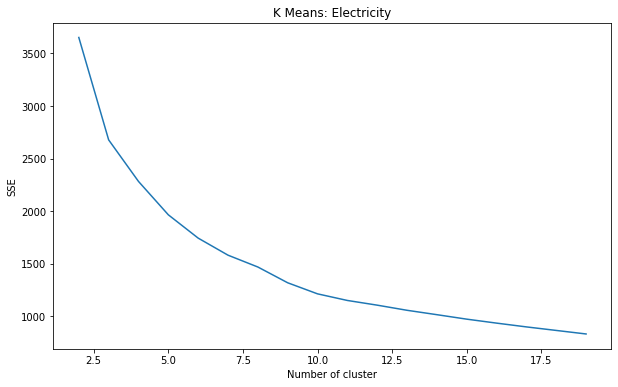

CPU times: user 32.7 s, sys: 5.76 s, total: 38.4 s
Wall time: 7.37 s


In [17]:
%%time

sse = {}
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, max_iter=1000, n_init=5, random_state=SEED).fit(df1_X)
    sse[cluster] = kmeans.inertia_
plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('K Means: Electricity')
plt.show()

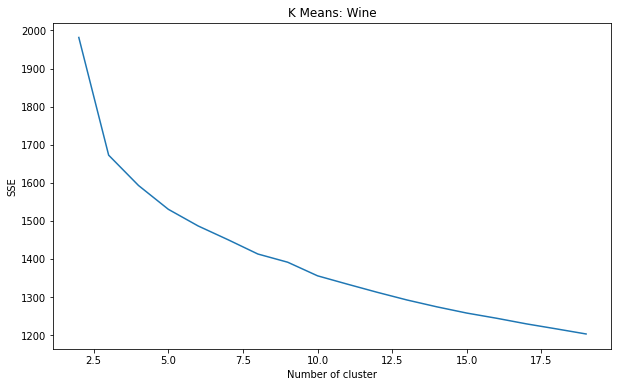

CPU times: user 14.5 s, sys: 3.2 s, total: 17.7 s
Wall time: 3.35 s


In [18]:
%%time

sse = {}
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, max_iter=1000, n_init=5, random_state=SEED).fit(df2_X)
    sse[cluster] = kmeans.inertia_
plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('K Means: Wine')
plt.show()

100%|██████████| 18/18 [09:49<00:00, 32.74s/it]


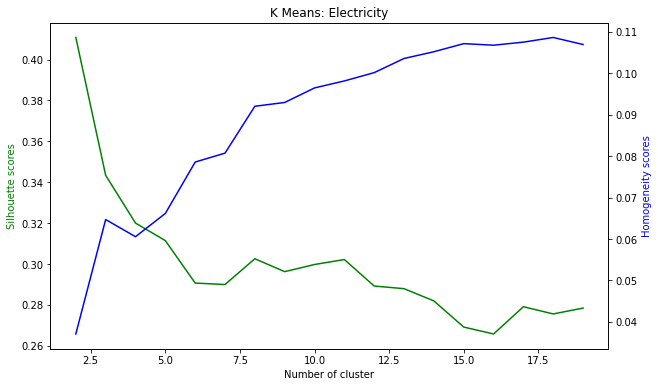

In [19]:
X = df1_X.copy()
y = df1_y.copy()

clusters = np.arange(2, 20)
silh_scores = []
homog_scores = []
for cluster in tqdm(clusters):
    kmeans = KMeans(n_clusters=cluster, max_iter=1000, n_init=5, random_state=SEED).fit(X)
    pred = kmeans.predict(X)
    silh_scores.append(silhouette_score(X, pred, metric='euclidean'))
    homog_scores.append(homogeneity_score(y, pred))

fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()
ax1.plot(clusters, silh_scores, 'g-')
ax2.plot(clusters, homog_scores, 'b-')

ax1.set_xlabel('Number of cluster')
ax1.set_ylabel('Silhouette scores', color='g')
ax2.set_ylabel('Homogeneity scores', color='b')
plt.title('K Means: Electricity')

plt.show()


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


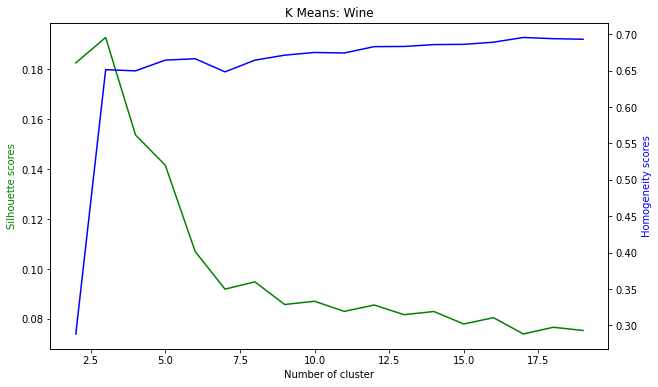

In [20]:
X = df2_X.copy()
y = df2_y.copy()

clusters = np.arange(2, 20)
silh_scores = []
homog_scores = []
for cluster in tqdm(clusters):
    kmeans = KMeans(n_clusters=cluster, max_iter=1000, n_init=5, random_state=SEED).fit(X)
    pred = kmeans.predict(X)
    silh_scores.append(silhouette_score(X, pred, metric='euclidean'))
    homog_scores.append(homogeneity_score(y, pred))

fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()
ax1.plot(clusters, silh_scores, 'g-')
ax2.plot(clusters, homog_scores, 'b-')

ax1.set_xlabel('Number of cluster')
ax1.set_ylabel('Silhouette scores', color='g')
ax2.set_ylabel('Homogeneity scores', color='b')
plt.title('K Means: Wine')

plt.show()


# EM

100%|██████████| 18/18 [13:31<00:00, 45.06s/it]


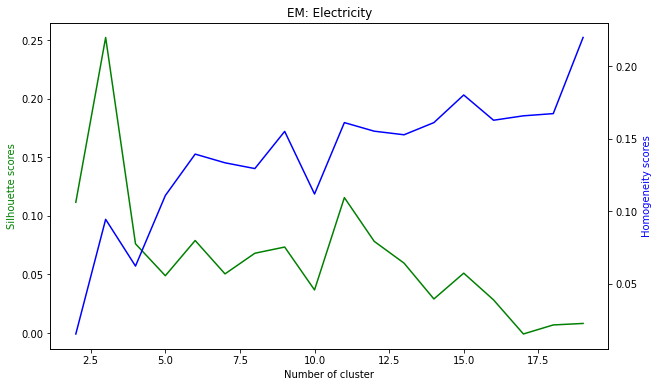

In [11]:
X = df1_X.copy()
y = df1_y.copy()

clusters = np.arange(2, 20)

silh_scores = []
homog_scores = []

for cluster in tqdm(clusters):
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=SEED, 
                          n_init=5).fit(X)
    label = gmm.predict(X)
    silh_scores.append(silhouette_score(X, label, metric='euclidean'))
    homog_scores.append(homogeneity_score(y, label))

    
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()
ax1.plot(clusters, silh_scores, 'g-')
ax2.plot(clusters, homog_scores, 'b-')

ax1.set_xlabel('Number of cluster')
ax1.set_ylabel('Silhouette scores', color='g')
ax2.set_ylabel('Homogeneity scores', color='b')
plt.title('EM: Electricity')

plt.show()

100%|██████████| 18/18 [01:00<00:00,  3.35s/it]


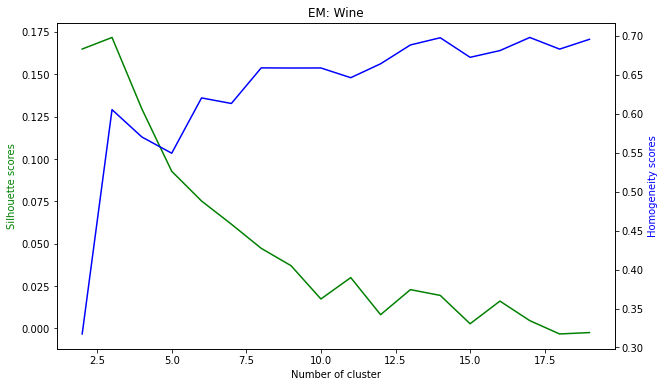

In [12]:
X = df2_X.copy()
y = df2_y.copy()

clusters = np.arange(2, 20)

silh_scores = []
homog_scores = []

for cluster in tqdm(clusters):
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=SEED, 
                          n_init=5).fit(X)
    label = gmm.predict(X)
    silh_scores.append(silhouette_score(X, label, metric='euclidean'))
    homog_scores.append(homogeneity_score(y, label))

    
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()
ax1.plot(clusters, silh_scores, 'g-')
ax2.plot(clusters, homog_scores, 'b-')

ax1.set_xlabel('Number of cluster')
ax1.set_ylabel('Silhouette scores', color='g')
ax2.set_ylabel('Homogeneity scores', color='b')
plt.title('EM: Wine')

plt.show()

# NN

In [12]:
kmeans = KMeans(n_clusters=3, n_init=5, max_iter=1000, random_state=SEED).fit(df2_X)
km_feats = kmeans.labels_.reshape(-1, 1)

gmm = GaussianMixture(n_components=3, max_iter=100, random_state=SEED, 
                          n_init=5).fit(df2_X)
gmm_feats = gmm.predict(df2_X).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(df2_X, 
                                                    df2_y, 
                                                    test_size=0.33, 
                                                    random_state=SEED,
                                                    stratify=df2_y)

X_train_km, X_test_km, y_train_km, y_test_km = train_test_split(km_feats, 
                                                    df2_y, 
                                                    test_size=0.33, 
                                                    random_state=SEED,
                                                    stratify=df2_y)

X_train_em, X_test_em, y_train_em, y_test_em = train_test_split(gmm_feats, 
                                                    df2_y, 
                                                    test_size=0.33, 
                                                    random_state=SEED,
                                                    stratify=df2_y)

In [13]:
param_grid = {
    'hidden_layer_sizes': [(16,16), (16,32), (32, 32)],
    "alpha" : [0.1, 0.01, 0.001]
}
cv = GridSearchCV(MLPClassifier(), param_grid, cv=10, 
                         scoring='f1_weighted', n_jobs=-2)
cv.fit(X_train_km, y_train_km)

print(cv.best_estimator_)


MLPClassifier(alpha=0.1, hidden_layer_sizes=(16, 16))


In [14]:
nn = MLPClassifier(alpha=cv.best_estimator_.alpha, hidden_layer_sizes=cv.best_estimator_.hidden_layer_sizes)
nn.fit(X_train_km, y_train_km)

pred = nn.predict(X_test_km)
print(classification_report(pred, y_test_km))

              precision    recall  f1-score   support

           1       0.92      0.89      0.90       535
           2       0.88      0.92      0.90       635
           3       0.91      0.88      0.90       480

    accuracy                           0.90      1650
   macro avg       0.90      0.90      0.90      1650
weighted avg       0.90      0.90      0.90      1650



In [15]:
param_grid = {
    'hidden_layer_sizes': [(16,16), (16,32), (32, 32)],
    "alpha" : [0.1, 0.01, 0.001]
}
cv = GridSearchCV(MLPClassifier(), param_grid, cv=10, 
                         scoring='f1_weighted', n_jobs=-2)
cv.fit(X_train_em, y_train_em)

print(cv.best_estimator_)



MLPClassifier(alpha=0.1, hidden_layer_sizes=(16, 16))


In [16]:
nn = MLPClassifier(alpha=cv.best_estimator_.alpha, hidden_layer_sizes=cv.best_estimator_.hidden_layer_sizes)
nn.fit(X_train_em, y_train_em)

pred = nn.predict(X_test_em)
print(classification_report(pred, y_test_em))

              precision    recall  f1-score   support

           1       0.92      0.88      0.90       546
           2       0.76      0.95      0.85       533
           3       0.94      0.77      0.85       571

    accuracy                           0.86      1650
   macro avg       0.88      0.87      0.86      1650
weighted avg       0.88      0.86      0.86      1650



## NN from assignment 1

In [40]:
best_nn = MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32, 32), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best_nn.fit(X_train, y_train)

pred = best_nn.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.91      0.93      0.92       521
           2       0.94      0.92      0.93       664
           3       0.94      0.93      0.93       465

    accuracy                           0.93      1650
   macro avg       0.93      0.93      0.93      1650
weighted avg       0.93      0.93      0.93      1650

